In [361]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import os

In [362]:
os.listdir('open')

['sample_submission.csv',
 'test_features.csv',
 'train_features.csv',
 'train_labels.csv']

In [363]:
data = pd.read_csv('open/train_features.csv')
label = pd.read_csv('open/train_labels.csv')
display(data)
data.iloc[:, 2:].describe()

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
count,1.875000e+06,1.875000e+06,1.875000e+06,1.875000e+06,1.875000e+06,1.875000e+06
mean,-4.489683e-01,-1.617913e-01,5.571471e-02,-1.307982e+00,-4.337745e-01,8.864100e-01
std,7.173082e-01,5.872018e-01,4.724824e-01,6.083228e+01,7.329832e+01,7.063345e+01
min,-8.838427e+00,-9.299714e+00,-8.316425e+00,-1.811127e+03,-1.594256e+03,-1.346143e+03
25%,-9.625643e-01,-5.163020e-01,-2.123550e-01,-2.048984e+01,-1.865320e+01,-1.546226e+01
50%,-6.560482e-01,-2.033985e-01,3.031258e-02,-1.421819e+00,-2.642753e-01,-1.798643e-01
75%,-1.701162e-04,1.406493e-01,3.581982e-01,1.572245e+01,1.676328e+01,1.641878e+01
max,8.426799e+00,8.484622e+00,6.432668e+00,1.870256e+03,2.111657e+03,1.255849e+03


,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
...,...,...,...
3120,3120,26,Non-Exercise
3121,3121,26,Non-Exercise
3122,3122,15,Dynamic Stretch (at your own pace)
3123,3123,26,Non-Exercise


<AxesSubplot:>

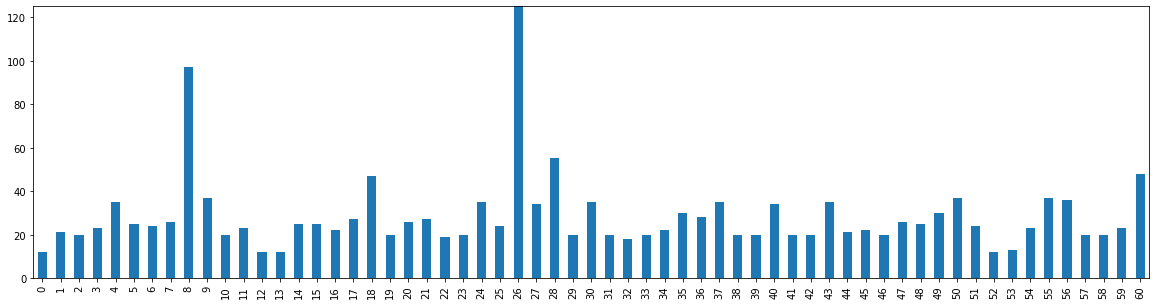

In [364]:
display(label)
plt.figure(figsize=(20, 5))
plt.ylim(0, 125)
label['label'].value_counts().plot.bar()

Triceps Kickback (knee on bench) (label spans both arms)


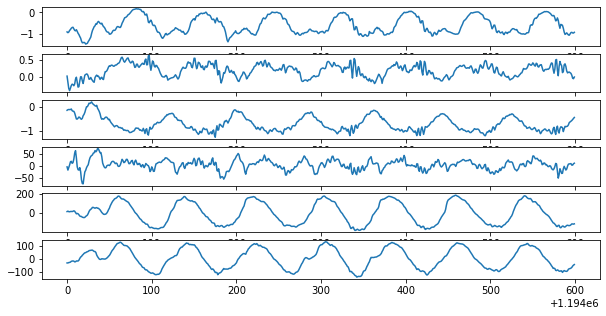

In [365]:
unique_ids = data['id'].unique()
rnd_id = np.random.choice(unique_ids)
rnd_data = data[data['id']==rnd_id]

fig, axes = plt.subplots(6, 1, figsize=(10, 5))
print(label[label['id']==rnd_id].iloc[0, 2])
for i, ax in enumerate(axes):
    ax.plot(rnd_data.iloc[:, 2+i])

In [366]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':.6f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self._list = []

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        self._list.append(self.avg)

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)
    
def get_inout_seq(seq, len_seq, len_pred):
    inout_seq = []
    L = len(seq)
    for i in range(0, L-len_pred, len_pred):
        input_seq = seq

In [373]:
class GRU_classifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size, device):
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.device = device
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=False, dropout=0.2)
        self.relu = nn.ReLU()
        self.dense1 = nn.Linear(hidden_size, output_size*2)
        self.dense2 = nn.Linear(output_size*2, output_size)
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, input_):
        hidden = self.init_hidden()
        input_ = input_.view(len(input_), self.batch_size, -1)
        output, hidden = self.gru(input_, hidden)
        output = self.relu(output[-1, :, :].squeeze())
        output = self.dense1(output)
        output = self.relu(output)
        output = self.dense2(output)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(self.num_layers, self.batch_size, self.hidden_size, device=self.device)
    

class Exercise_dataset(Dataset):
    def __init__(self, df, label, device):
        self.df = df
        self.label = label
        self.device = device
        self.unique_labels = label['label'].unique()
        
        self.enc = OneHotEncoder(sparse=False)
        self.enc.fit(label['label'].unique()[:, np.newaxis])
        
    def __len__(self):
        return len(self.unique_labels)
    
    def __getitem__(self, idx):
        idx = idx % len(self.unique_labels)
        sample = dict()
        sample['seq'] = torch.Tensor(self.df[self.df['id']==idx].iloc[:, 2:].values, device=self.device)
        sample['label'] = torch.Tensor(enc.transform([[idx]]), device=self.device)
        
        return sample

In [374]:
BATCH_SIZE = 1
N_EPOCHS = 30
VIS_FREQ = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

unique_ids = data['id'].unique()
cv = KFold(n_splits=5,
           random_state=42,
           shuffle=True)

for k, (train_id, valid_id) in enumerate(cv.split(unique_ids)):
    print(f'Fold {k} ' + '='*50)
    X_train = data[data['id'].isin(train_id)]
    y_train = label[label['id'].isin(train_id)]
    X_valid = data[data['id'].isin(valid_id)]
    y_valid = label[label['id'].isin(valid_id)]
    
    train_dataset = Exercise_dataset(X_train, y_train, device)
    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=True)
    valid_dataset = Exercise_dataset(X_valid, y_valid, device)
    valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=True, drop_last=True)

    model = GRU_classifier(input_size=6,
                           hidden_size=36,
                           num_layers=2,
                           output_size=len(label['label'].unique()),
                           batch_size=1,
                           device=device)

    loss_CE = nn.CrossEntropyLoss()
    optim = torch.optim.AdamW(model.parameters(), lr=1e-03, weight_decay=1e-02)
    
    loss_train = AverageMeter('loss_train', ':.6f')
    loss_valid = AverageMeter('loss_valid', ':.6f')

    for epoch in range(N_EPOCHS):
        for i, (train_sample, valid_sample) in enumerate(zip(train_dataloader, valid_dataloader)):
            train_seq = train_sample['seq']
            train_label = train_sample['label']
            train_seq = train_seq.transpose(0, 1)
            train_label = train_label.transpose(0, 1)
            
            optim.zero_grad()
            
            pred, hidden = model(train_seq)
                
            print(f'pred : {pred.size()}')
            print(f'label : {train_label.squeeze().size()}')
            loss = loss_CE(pred, train_label.squeeze())
            loss_train.update(loss.item())
            
            loss.backward()
            optim.step()
            
            with torch.no_grad():
                valid_seq = valid_sample['seq']
                valid_label = valid_sample['label']
                valid_seq = valid_seq.transpose(0, 1)
                valid_label = valid_label.transpose(0, 1)
                
                pred, hidden = model(valid_seq)
                loss = loss_CE(pred, hidden)
                loss_valid.update(loss.item())
        
        if epoch % VIS_FREQ == 0:
            print(f'Epoch[{epoch}] : {loss_train}, {loss_valid}')

Fold 0 ==================================================
pred : torch.Size([61])
label : torch.Size([61])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)